In [1]:
import numpy as np
import pandas as pd
from skbio.stats.composition import clr
import matplotlib.pyplot as plt
import seaborn as sns
from skbio.diversity.alpha import shannon
from scipy.stats import pearsonr
from scipy.stats import mannwhitneyu
sns.set(rc={'axes.facecolor':'white', 
            'figure.facecolor':'white', 
            'axes.edgecolor':'black', 
            'grid.color': 'black'
            }, 
       font_scale=2)

def rescale(xx):
    return(xx/xx.sum(axis=1)[:, np.newaxis] )

def add_15_percent_to_top_ylim(ax):
    ylim=ax.get_ylim() 
    ax.set_ylim( ylim[0], ylim[1] + ( ylim[1] - ylim[0] ) * .15)
    return(None)
hide_axes=True


In [2]:
def make_shannon_plot(df, 
                      md
                     ):
    sh_alphas = [shannon(x) for x in df.values]
    md['Shannon_diversities'] = sh_alphas

    mw = mannwhitneyu( *[md.loc[md.grouping==a].Shannon_diversities
                       for a in md.grouping.unique()]
                       )

    plt.figure(figsize=(12 * .3,7))
    if df.shape[0]<=100:
        ax=sns.boxplot(x = md.grouping, 
                    y=md.Shannon_diversities, 
                    fliersize=0
                   )
    else:
        ax=sns.boxplot(x = md.grouping, 
                    y=md.Shannon_diversities, 
                   )
        
    if df.shape[0]<=100: # make swarmplot if we don't have too many points
        sns.swarmplot(x = md.grouping, 
                      y=md.Shannon_diversities, 
                      size=5, 
                      color='black', 
                      ax=ax
                      )

    plt.ylabel('Shannon diversity')
    plt.xlabel(None)
    plt.title('Mann Whitney U p = {:.1e}\n'.format(mw.pvalue))
    plt.xticks(rotation=90)
    return(ax)

    

In [3]:
def make_ra_feature_plot(df, 
                         md, 
                         val,
                         pseudocount=0
                         ):

    val_ = np.where(df.columns == val)[0][0]
    X_ra = rescale(df.values+pseudocount) 
    md['ra'] = X_ra[:, val_]

    try:
        mw = mannwhitneyu( *[md.loc[md.grouping==a].ra
                           for a in md.grouping.unique()]
                           )
        pval=mw.pvalue
    except:
        pval = 1000
        
    plt.figure(figsize=(12 * .3,7))

    if df.shape[0]<=100: 
        ax = sns.boxplot(x = md.grouping, 
                         y=X_ra[:,val_], 
                         fliersize=0
                         )
    else:
        ax = sns.boxplot(x = md.grouping, 
                         y=X_ra[:,val_], 
                         )

    if df.shape[0]<=100: # make swarmplot if we don't have too many points
        sns.swarmplot(x = md.grouping, 
                      y=X_ra[:,val_], 
                      size=5, 
                      color='black', 
                      ax=ax
                      )
    plt.ylabel("{}'s relative abundance".format(val.split('g__')[-1]))
    plt.xlabel(None)
    plt.title( 'Mann Whitney U p = {:.1e}\n'.format(pval) )
    plt.xticks(rotation=90)
    return(ax)



def make_clr_feature_plot(df, 
                          md, 
                          val,
                          pseudocount='minimal_value'
                          ):

    val_ = np.where(df.columns == val)[0][0]
    
    if pseudocount =='minimal_value':
        val_ = np.where(df.columns == val)[0][0]
        rsc_df = rescale(df.values)
        X_clr = clr(rsc_df + 10**np.floor(np.log10(rsc_df[rsc_df != 0].min())))
    elif pseudocount=='one':
         X_clr = clr(rescale(1 + df.values)  )
    else:
        Raise(ValueError('pseudocount must be either `minimal_value` or `one`'))
    
    md['clre'] = X_clr[:, val_]


    mw = mannwhitneyu( *[md.loc[md.grouping==a].clre
                       for a in md.grouping.unique()]
                       )
    plt.figure(figsize=(12 * .3,7))
    if df.shape[0]<=100: 
        ax = sns.boxplot(x = md.grouping, 
                         y=X_clr[:,val_], 
                         fliersize=0
                         )
        
    else:
        ax = sns.boxplot(x = md.grouping, 
                         y=X_clr[:,val_], 
                         )

    if df.shape[0]<=100: # make swarmplot if we don't have too many points
        sns.swarmplot(x = md.grouping, 
                      y=X_clr[:,val_], 
                      size=5, 
                      color='black', 
                      ax=ax
                      )
    plt.ylabel("{}'s centered log ratio".format(val.split('g__')[-1]))
    plt.xlabel(None)
    plt.title( 'Mann Whitney U p = {:.1e}\n'.format(mw.pvalue) )
    plt.xticks(rotation=90)
    return(ax)




## their fig 2

In [4]:
df = pd.read_csv('Kraken-TCGA-Raw-Data-17625-Samples.csv', index_col=0)
md = pd.read_csv('Metadata-TCGA-All-18116-Samples.csv', index_col=0).loc[df.index]

df=df.loc[df.index.isin(md.index)]
md=md.loc[md.index.isin(df.index)].loc[df.index]


cols = pd.read_csv('Kraken-TCGA-Voom-SNM-Most-Stringent-Filtering-Data.csv', 
            index_col=0, nrows=1).columns
df = df.loc[:, cols[cols.str.contains('contaminant')==False]]
df_vsnm=pd.read_csv('Kraken-TCGA-Voom-SNM-Most-Stringent-Filtering-Data.csv', 
            index_col=0).loc[md.index]

md['grouping'] = md.disease_type == 'Adrenocortical Carcinoma'
xaxis_name = 'Adrenocortical Carcinoma'

save_path = 'tcga_plots-no-axes/Fig-2-Adrenocortical-Carcinoma-Hepandensovirus'
val = df.columns[df.columns.str.contains('Hepandensovirus')].values[0]

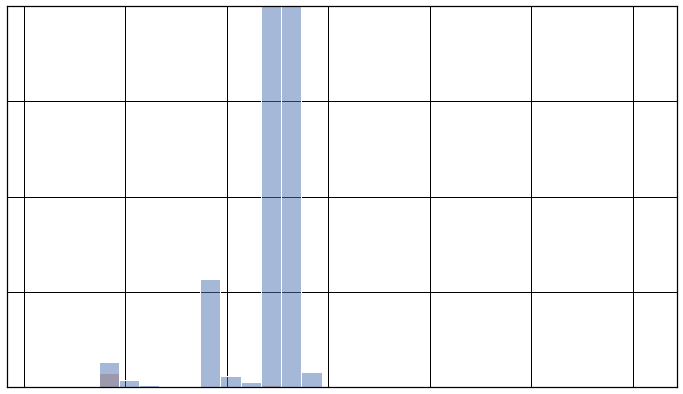

In [5]:

val_vsnm = df_vsnm.columns[df_vsnm.columns.str.contains('Hepandensovirus')].values[0]
plt.figure(figsize=(12,7))
# plt.semilogy()
inds=df_vsnm[val] < 3.1
ax=sns.histplot(x=df_vsnm.loc[inds][val_vsnm].values, 
             hue = md.loc[inds].grouping.values, 
             bins=30
             )
ax.set_yticks(np.linspace(0, 2000, 5))
ax.legend_.set_title('Adrenocortical Carcinoma')
plt.ylim(0, 2000)
if hide_axes:
    ax.get_legend().remove()
    ax.set(
           yticklabels=[], 
           xticklabels=[])
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-VSNM.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
            )

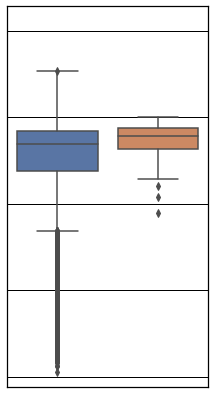

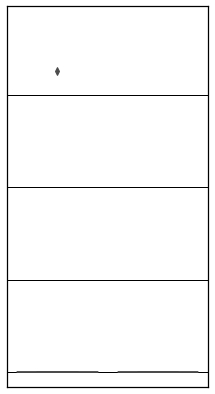

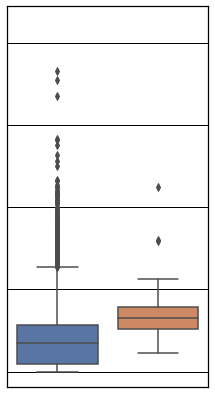

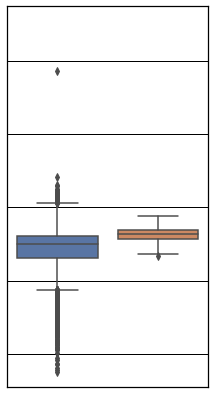

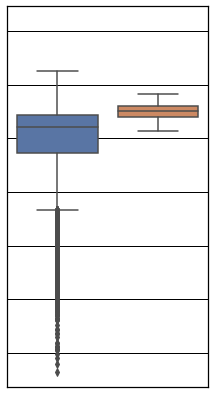

In [6]:
val = df.columns[df.columns.str.contains('Hepandensovirus')].values[0]
ax=make_shannon_plot(df, 
                      md
                     )
ax.set_xlabel(xaxis_name)
# ax.set_ylim(1.5,3.8)
add_15_percent_to_top_ylim(ax)
if hide_axes:
    ax.set(yticklabels=[], 
           xticklabels=[])
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-Shannon.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
            )
plt.show()

ax=make_ra_feature_plot(df, 
                      md, 
                      val
                      )
ax.set_xlabel(xaxis_name)
add_15_percent_to_top_ylim(ax)
if hide_axes:
    ax.set(yticklabels=[], 
           xticklabels=[] )
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-RA.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
           )

plt.show()


ax=make_ra_feature_plot(df, 
                        md, 
                        val,
                        pseudocount=1
                      )
ax.set_xlabel(xaxis_name)
add_15_percent_to_top_ylim(ax)
if hide_axes:
    ax.set(yticklabels=[], 
           xticklabels=[] )
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-RA-with-pseudocount.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
           )

plt.show()





ax=make_clr_feature_plot(df, 
                      md, 
                      val
                      )
ax.set_xlabel(xaxis_name)
add_15_percent_to_top_ylim(ax)
if hide_axes:
    ax.set(yticklabels=[], 
           xticklabels=[])
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-CLR.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
           )
plt.show()

ax=make_clr_feature_plot(df, 
                         md, 
                         val,
                         pseudocount='one'
                          )
ax.set_xlabel(xaxis_name)
add_15_percent_to_top_ylim(ax)
if hide_axes:
    ax.set(yticklabels=[], 
           xticklabels=[])
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-CLR-pseudocount-one.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
           )
plt.show()

## their fig 3

In [7]:
df = pd.read_csv('Kraken-TCGA-Raw-Data-17625-Samples.csv', index_col=0)
md = pd.read_csv('Metadata-TCGA-All-18116-Samples.csv', index_col=0).loc[df.index]
md=md.loc[md.experimental_strategy=='WGS']
md=md.loc[(md.sample_type!='Blood Derived Normal')&\
          (md.disease_type=='Kidney Chromophobe')]

df=df.loc[df.index.isin(md.index)]
md=md.loc[md.index.isin(df.index)].loc[df.index]

md = md.sort_values('sample_type', ascending=False)
df=df.loc[md.index]


cols=  pd.read_csv('Kraken-TCGA-Voom-SNM-All-Putative-Contaminants-Removed-Data.csv', 
            index_col=0, nrows=1).columns
df = df.loc[:, cols[cols.str.contains('contaminant')==False]]

md['grouping'] = md.sample_type
save_path = 'tcga_plots-no-axes/Fig-3-KICH-WGS-Thiorhodospira'
val = df.columns[df.columns.str.contains('Thiorhodospira')].values[0]

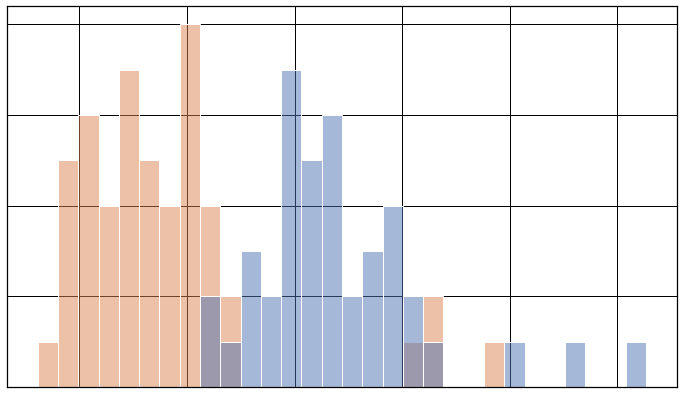

In [8]:
df_vsnm = pd.read_csv('Kraken-TCGA-Voom-SNM-All-Putative-Contaminants-Removed-Data.csv', 
                      index_col=0 ).loc[md.index]
plt.figure(figsize=(12,7))
ax=sns.histplot(x=df_vsnm[val].values, 
                hue = md.grouping.values, 
                bins=30
                )
if hide_axes:
    ax.get_legend().remove()
    ax.set(
           yticklabels=[], 
           xticklabels=[])
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-VSNM.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
            )

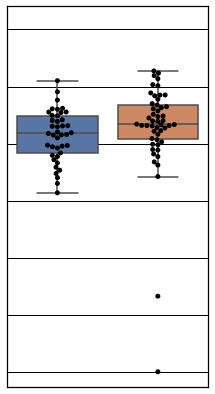

/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 56.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/george/opt/anaconda3/envs/pl2/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 62.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


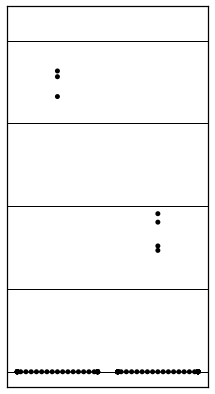

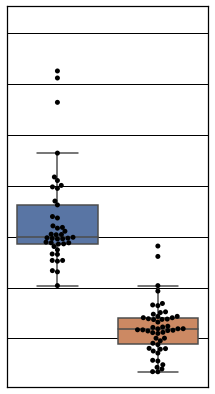

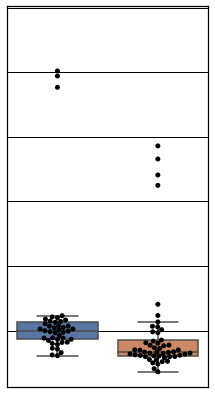

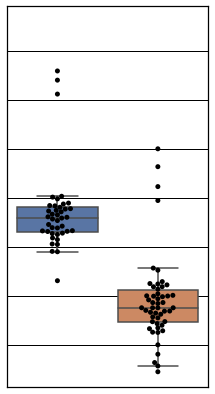

In [9]:
val = df.columns[df.columns.str.contains('Thiorhodospira')].values[0]
ax=make_shannon_plot(df, 
                      md
                     )
add_15_percent_to_top_ylim(ax)
if hide_axes:
    ax.set(yticklabels=[], 
           xticklabels=[])
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-Shannon.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
           )
plt.show()

ax=make_ra_feature_plot(df, 
                      md, 
                      val
                      )
add_15_percent_to_top_ylim(ax)
if hide_axes:
    ax.set(yticklabels=[], 
           xticklabels=[])
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-RA.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
           )
plt.show()

ax=make_ra_feature_plot(df, 
                        md, 
                        val,
                        pseudocount=1
                      )
add_15_percent_to_top_ylim(ax)
if hide_axes:
    ax.set(yticklabels=[], 
           xticklabels=[] )
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-RA-with-pseudocount.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
           )

plt.show()



ax=make_clr_feature_plot(df, 
                      md, 
                      val
                      )
add_15_percent_to_top_ylim(ax)
if hide_axes:
    ax.set(yticklabels=[], 
           xticklabels=[])
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-CLR.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
           )
plt.show()


ax=make_clr_feature_plot(df, 
                         md, 
                         val,
                         pseudocount='one'
                          )
ax.set_xlabel(xaxis_name)
add_15_percent_to_top_ylim(ax)
if hide_axes:
    ax.set(yticklabels=[], 
           xticklabels=[])
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-CLR-pseudocount-one.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
           )
plt.show()

## fig 4

In [10]:
df = pd.read_csv('Kraken-TCGA-Raw-Data-17625-Samples.csv', index_col=0)
md = pd.read_csv('Metadata-TCGA-All-18116-Samples.csv', index_col=0).loc[df.index]
md = md.loc[ md.sample_type == 'Primary Tumor' ]
df=df.loc[df.index.isin(md.index)]
md=md.loc[md.index.isin(df.index)].loc[df.index]

cols=  pd.read_csv('Kraken-TCGA-Voom-SNM-All-Putative-Contaminants-Removed-Data.csv', 
            index_col=0, nrows=1).columns
df = df.loc[:, cols[cols.str.contains('contaminant')==False]]

md['grouping'] = md.disease_type=='Lung Squamous Cell Carcinoma'
xaxis_name = 'Lung Squamous Cell Carcinoma'

save_path = 'tcga_plots-no-axes/Fig-4-Lung-Squamous-Cell-Carcinoma-Nitrospira'
val = 'k__Bacteria.p__Nitrospirae.c__Nitrospira.o__Nitrospirales.f__Nitrospiraceae.g__Nitrospira'



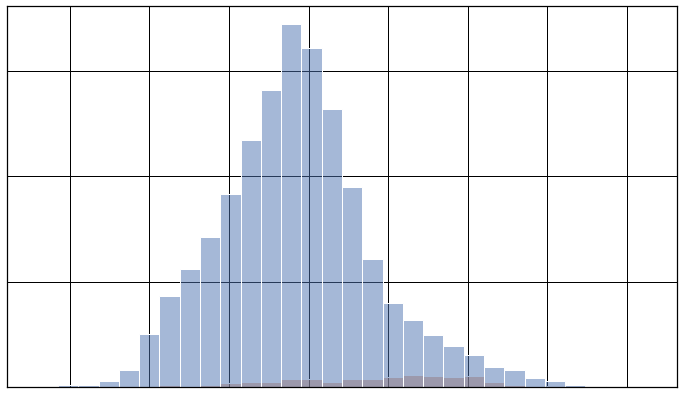

In [11]:
df_vsnm = pd.read_csv('Kraken-TCGA-Voom-SNM-All-Putative-Contaminants-Removed-Data.csv', 
                      index_col=0 ).loc[md.index]
plt.figure(figsize=(12,7))
ax=sns.histplot(x=df_vsnm[val].values, 
                hue = md.grouping.values, 
                bins=30
                )
ax.set_yticks(np.linspace(0, 1500, 4)) 
if hide_axes:
    ax.get_legend().remove()
    ax.set(
           yticklabels=[], 
           xticklabels=[])
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-VSNM.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
            )

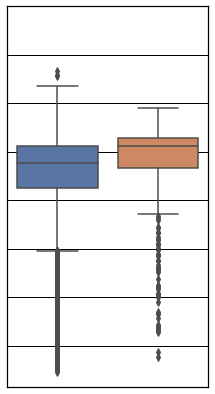

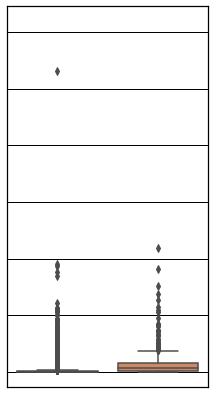

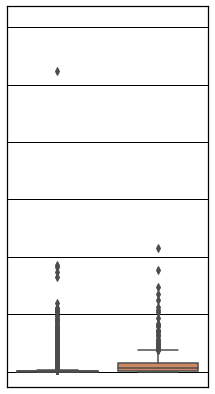

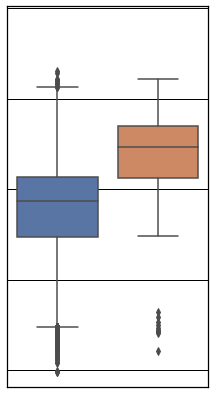

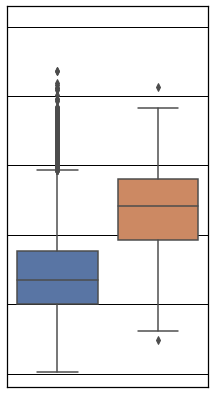

In [12]:
ax=make_shannon_plot(df, 
                      md
                     )
ax.set_xlabel(xaxis_name)
# ax.set_ylim(2.8, 6.5)
add_15_percent_to_top_ylim(ax)
if hide_axes:
    ax.set(yticklabels=[], 
           xticklabels=[])
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-Shannon.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
           )
plt.show()

ax=make_ra_feature_plot(df, 
                        md, 
                        val
                        )
ax.set_xlabel(xaxis_name)
# ax.set_ylim(-0.0001, 0.003)
add_15_percent_to_top_ylim(ax)
if hide_axes:
    ax.set(yticklabels=[], 
           xticklabels=[])
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-RA.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
           )
plt.show()

ax=make_ra_feature_plot(df, 
                        md, 
                        val,
                        pseudocount=1
                      )
ax.set_xlabel(xaxis_name)
add_15_percent_to_top_ylim(ax)
if hide_axes:
    ax.set(yticklabels=[], 
           xticklabels=[] )
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-RA-with-pseudocount.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
           )

plt.show()



ax=make_clr_feature_plot(df, 
                      md, 
                      val
                      )
ax.set_xlabel(xaxis_name)
add_15_percent_to_top_ylim(ax)
if hide_axes:
    ax.set(yticklabels=[], 
           xticklabels=[])
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-CLR.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
           )
plt.show()

ax=make_clr_feature_plot(df, 
                         md, 
                         val,
                         pseudocount='one'
                          )
ax.set_xlabel(xaxis_name)
add_15_percent_to_top_ylim(ax)
if hide_axes:
    ax.set(yticklabels=[], 
           xticklabels=[])
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-CLR-pseudocount-one.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
           )
plt.show()

## fig 5

In [13]:
df = pd.read_csv('Kraken-TCGA-Raw-Data-17625-Samples.csv', index_col=0)
md = pd.read_csv('Metadata-TCGA-All-18116-Samples.csv', index_col=0).loc[df.index]
md=md.loc[(md.primary_site=='Head and Neck')&\
          (md.sample_type.str.contains('Blood')==False)
         ]


md.loc[md.sample_type.str.contains('Metastatic'), 'sample_type'] = 'Primary Tumor'
df=df.loc[df.index.isin(md.index)]
md=md.loc[md.index.isin(df.index)].loc[df.index]

md = md.sort_values('sample_type', ascending=False)
df=df.loc[md.index]


cols = pd.read_csv('Kraken-TCGA-Voom-SNM-Most-Stringent-Filtering-Data.csv', 
                   index_col=0, 
                   nrows=1).columns
df = df.loc[:, cols[cols.str.contains('contaminant')==False]]

md['grouping'] = md.sample_type

val ='k__Viruses.o__Caudovirales.f__Myoviridae.g__Mulikevirus'
save_path = 'tcga_plots-no-axes/Fig-5-Head-and-Neck-Mulikevirus'

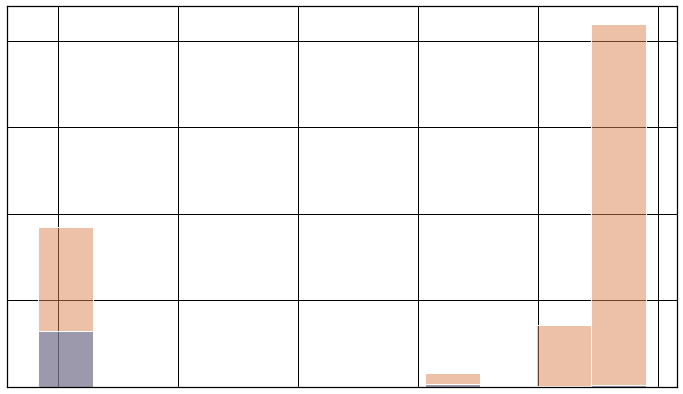

In [14]:
df_vsnm = pd.read_csv('Kraken-TCGA-Voom-SNM-Most-Stringent-Filtering-Data.csv', 
                        index_col=0).loc[md.index]
plt.figure(figsize=(12,7))
ax=sns.histplot(x=df_vsnm[val].values, 
                hue = md.grouping.values
                )
if hide_axes:
    ax.get_legend().remove()
    ax.set(
           yticklabels=[], 
           xticklabels=[])
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-VSNM.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
            )


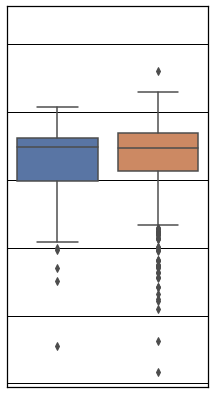

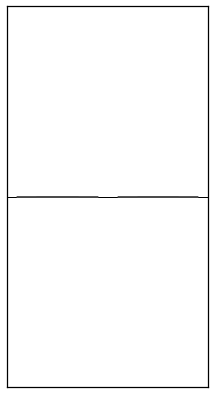

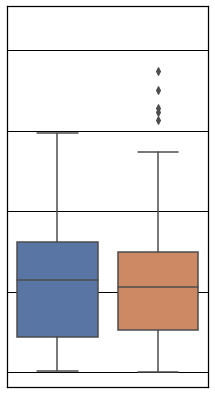

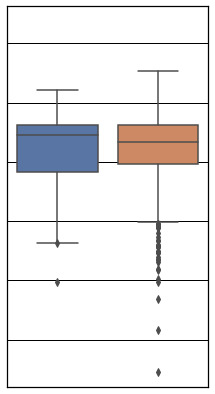

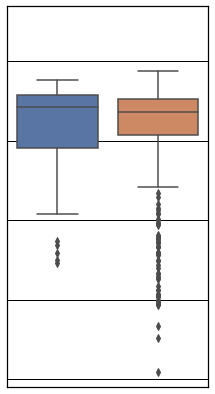

In [15]:
ax=make_shannon_plot(df, 
                  md
                  )
add_15_percent_to_top_ylim(ax)
if hide_axes:
    ax.set(yticklabels=[], 
           xticklabels=[])
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-Shannon.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
           )
plt.show()

ax=make_ra_feature_plot(df, 
                      md, 
                      val
                      )
ax.set_yticks([0])
if hide_axes:
    ax.set(yticklabels=[], 
           xticklabels=[])
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-RA.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
           )
plt.show()

ax=make_ra_feature_plot(df, 
                        md, 
                        val,
                        pseudocount=1
                      )
add_15_percent_to_top_ylim(ax)
if hide_axes:
    ax.set(yticklabels=[], 
           xticklabels=[] )
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-RA-with-pseudocount.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
           )

plt.show()




ax=make_clr_feature_plot(df, 
                      md, 
                      val
                      )
add_15_percent_to_top_ylim(ax)
if hide_axes:
    ax.set(yticklabels=[], 
           xticklabels=[])
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-CLR.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
           )
plt.show()

ax=make_clr_feature_plot(df, 
                         md, 
                         val,
                         pseudocount='one'
                          )
ax.set_xlabel(xaxis_name)
add_15_percent_to_top_ylim(ax)
if hide_axes:
    ax.set(yticklabels=[], 
           xticklabels=[])
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(None)
plt.savefig(save_path+'-CLR-pseudocount-one.pdf', 
            dpi=900, 
            bbox_inches='tight', 
            format='pdf'
           )
plt.show()